In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *
import os
from enum import Enum

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

torch.manual_seed(114514)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

___
**PREPROCESSING**
___

In [2]:
directory = '../dataset/tano'
filenames = [filename for filename in os.listdir(directory) if filename.endswith('.csv')]
labels = [filename.split('.')[0] for filename in filenames]
labels

['deep_breath',
 'dry_cough',
 'jumping_jack',
 'push_up',
 'random',
 'swallowing',
 'throat_clearing']

In [3]:
class Label(Enum):
    DEEP_BREATH = 0
    DRY_COUGH = 1
    JUMPING_JACK = 2
    PUSH_UP = 3
    SWORLOWING = 4
    THROAT_CLEARING = 5

BREATH

deep_breath.csv
torch.Size([16, 1])
torch.Size([16, 7, 2000])


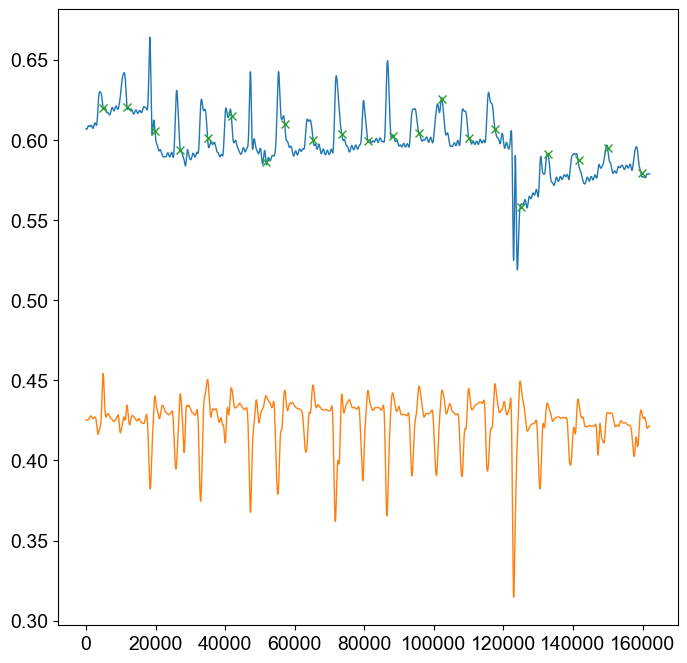

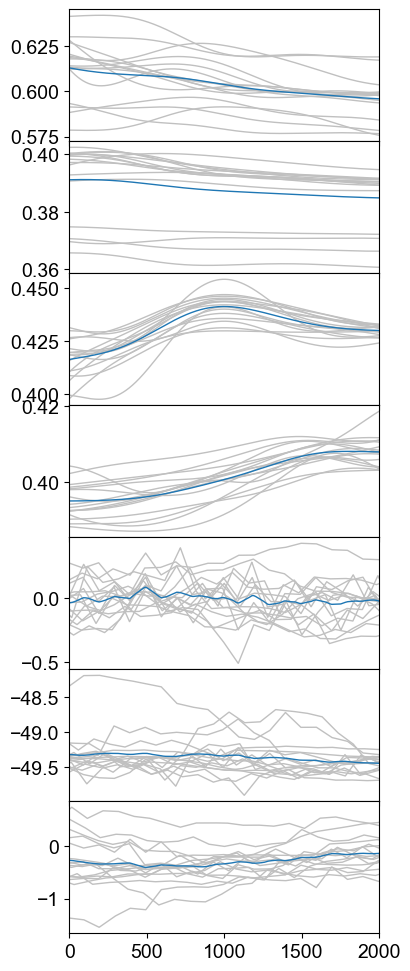

In [63]:
# deep breath
# Load
filename = filenames[0]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)

# NOTE: Manual manipulation only apply for 'tano/deep_breath.csv'
data_raw = data_raw.truncate(after=1620)

timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
# sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
# data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, 1, 'lowpass', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 2], distance=5000)

plt.figure(figsize=(8, 8))
plt.plot(timestamps, data[:, 0])
plt.plot(timestamps, data[:, 2])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(0, 50000)

# Construct slices_0
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_0 = []
for idx in range(expanded_peaks.shape[0]):
    slices_0.append(data[expanded_peaks[idx, :]])
slices_0 = np.array(slices_0)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_0,
                                                                            (1, 0, 2))]),
              axis=0)
slices_0 = slices_0[mask.astype(bool), :, :]
slices_0 = torch.tensor(np.transpose(slices_0, (0, 2, 1)))
labels_0 = torch.broadcast_to(torch.tensor(Label.DEEP_BREATH.value), (slices_0.shape[0], 1))
print(labels_0.shape)
print(slices_0.shape)

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(4, 12), sharex=True)
fig.subplots_adjust(hspace=0)
for r, ax in enumerate(axes):
    for idx in range(slices_0.shape[0]):
        ax.plot(slices_0[idx, r, :], 'silver')
    ax.plot(torch.mean(slices_0[:, r, :], axis=0))
    ax.set_xlim(0, 2000)
plt.show()

dry_cough.csv
torch.Size([19, 1])
torch.Size([19, 7, 2000])


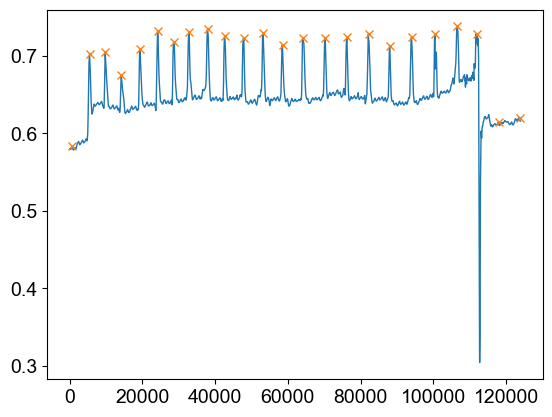

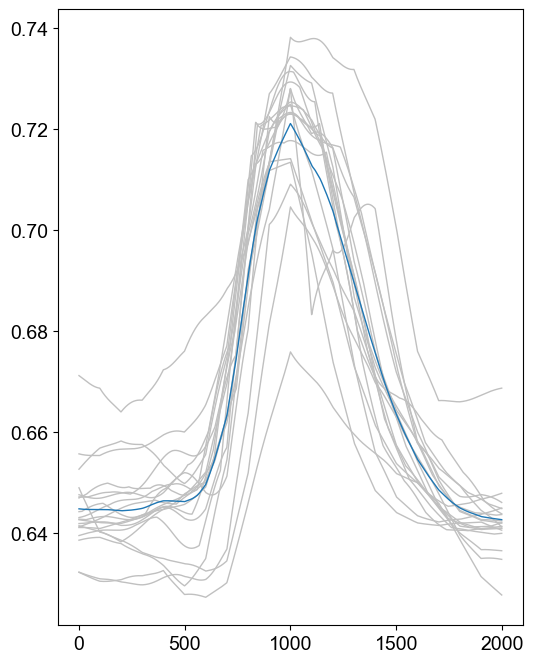

In [28]:
# dry cough
# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)

timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)

plt.plot(timestamps, data[:, 0])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(0, 20000)

# Construct slices
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_1 = []
for idx in range(expanded_peaks.shape[0]):
    slices_1.append(data[expanded_peaks[idx, :]])
slices_1 = np.array(slices_1)
mask = section_average(slices_1[:, :, 0])
slices_1 = slices_1[mask.astype(bool), :, :]
slices_1 = torch.tensor(np.transpose(slices_1, (0, 2, 1)))
labels_1 = torch.broadcast_to(torch.tensor(Label.DRY_COUGH.value), (slices_1.shape[0], 1))
print(labels_1.shape)
print(slices_1.shape)

plt.figure(figsize=(6, 8))
for idx in range(slices_1.shape[0]):
    plt.plot(slices_1[idx, 0, :], 'silver')
plt.plot(torch.mean(slices_1[:, 0, :], axis=0))
plt.show()

jumping_jack.csv
torch.Size([60, 1])
torch.Size([60, 7, 2000])


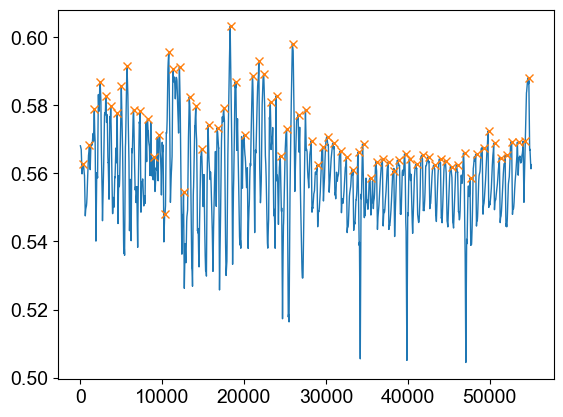

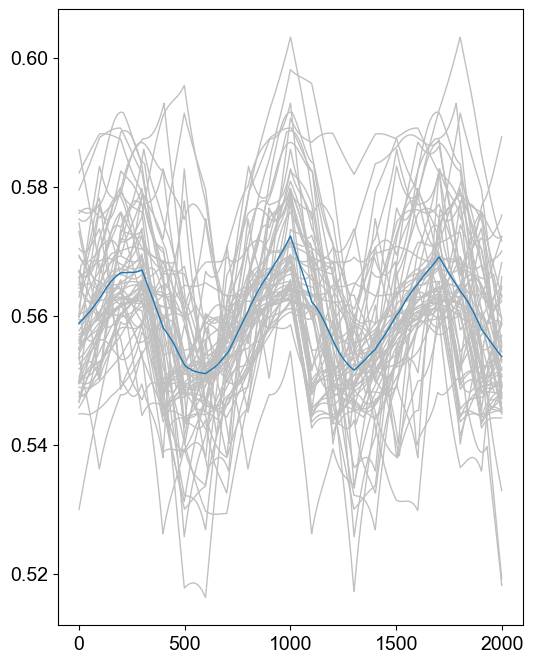

In [31]:
# jumping_jack
# Load
filename = filenames[2]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)

plt.plot(timestamps, data[:, 0])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(0, 20000)

# Construct slices_0
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_2 = []
for idx in range(expanded_peaks.shape[0]):
    slices_2.append(data[expanded_peaks[idx, :]])
slices_2 = np.array(slices_2)
mask = section_average(slices_2[:, :, 0])
slices_2 = slices_2[mask.astype(bool), :, :]
slices_2 = torch.tensor(np.transpose(slices_2, (0, 2, 1)))
labels_2 = torch.broadcast_to(torch.tensor(Label.JUMPING_JACK.value), (slices_2.shape[0], 1))
print(labels_2.shape)
print(slices_2.shape)

plt.figure(figsize=(6, 8))
for idx in range(slices_2.shape[0]):
    plt.plot(slices_2[idx, 0, :], 'silver')
plt.plot(torch.mean(slices_2[:, 0, :], axis=0))
plt.show()

swallowing.csv
torch.Size([19, 1])
torch.Size([19, 7, 2000])


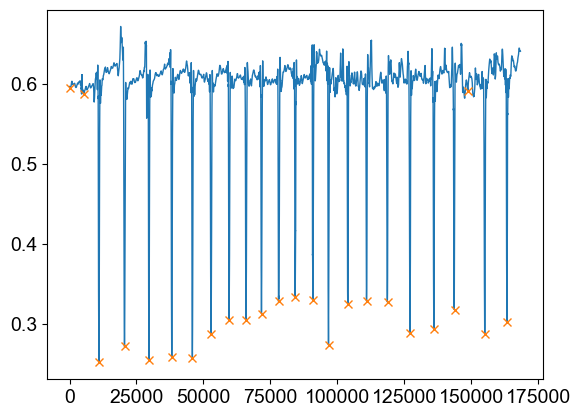

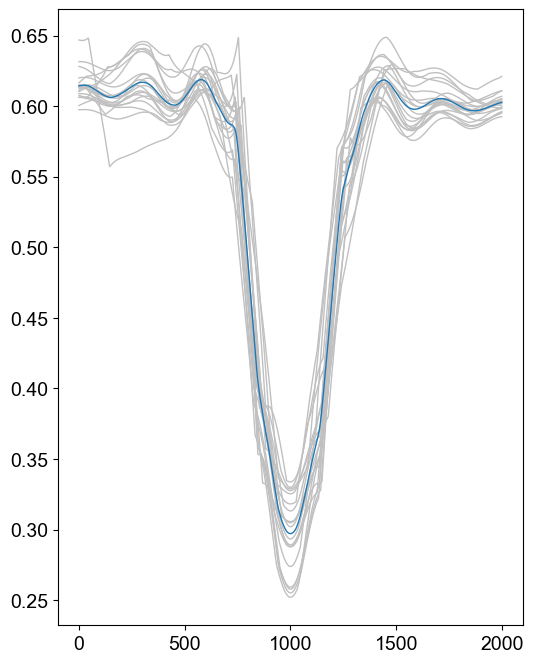

In [33]:
# swallowing
# Load
filename = filenames[5]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 0], distance=5000)

plt.plot(timestamps, data[:, 0])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(20000, 100000)

# Construct slices_3
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_3 = []
for idx in range(expanded_peaks.shape[0]):
    slices_3.append(data[expanded_peaks[idx, :]])
slices_3 = np.array(slices_3)
mask = section_average(slices_3[:, :, 0])
slices_3 = slices_3[mask.astype(bool), :, :]
slices_3 = torch.tensor(np.transpose(slices_3, (0, 2, 1)))
labels_3 = torch.broadcast_to(torch.tensor(Label.SWORLOWING.value), (slices_3.shape[0], 1))
print(labels_3.shape)
print(slices_3.shape)


plt.figure(figsize=(6, 8))
for idx in range(slices_3.shape[0]):
    plt.plot(slices_3[idx, 0, :], 'silver')
plt.plot(torch.mean(slices_3[:, 0, :], axis=0))
plt.show()

push_up.csv
torch.Size([84, 1])
torch.Size([84, 7, 2000])


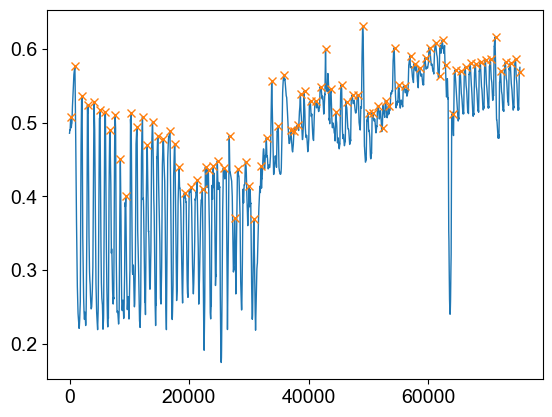

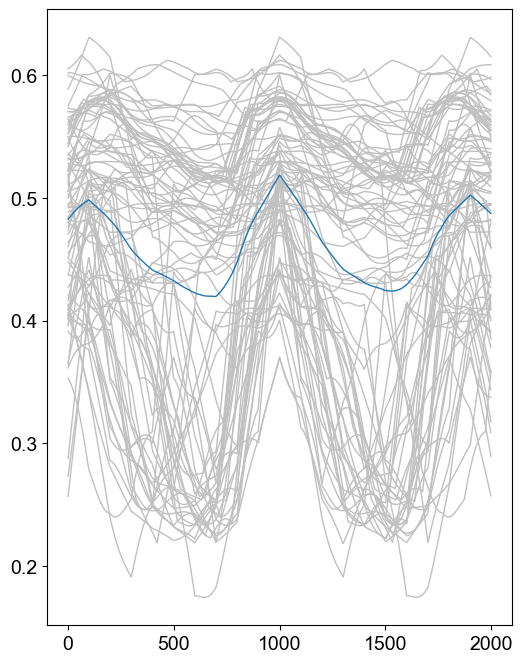

In [35]:
# push up
# Load
filename = filenames[3]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)

plt.plot(timestamps, data[:, 0])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(20000, 40000)

# Construct slices_4
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_4 = []
for idx in range(expanded_peaks.shape[0]):
    slices_4.append(data[expanded_peaks[idx, :]])
slices_4 = np.array(slices_4)
mask = section_average(slices_4[:, :, 0])
slices_4 = slices_4[mask.astype(bool), :, :]
slices_4 = torch.tensor(np.transpose(slices_4, (0, 2, 1)))
labels_4 = torch.broadcast_to(torch.tensor(Label.PUSH_UP.value), (slices_4.shape[0], 1))
print(labels_4.shape)
print(slices_4.shape)


plt.figure(figsize=(6, 8))
for idx in range(slices_4.shape[0]):
    plt.plot(slices_4[idx, 0, :], 'silver')
plt.plot(torch.mean(slices_4[:, 0, :], axis=0))
plt.show()

throat_clearing.csv
torch.Size([26, 1])
torch.Size([26, 7, 2000])


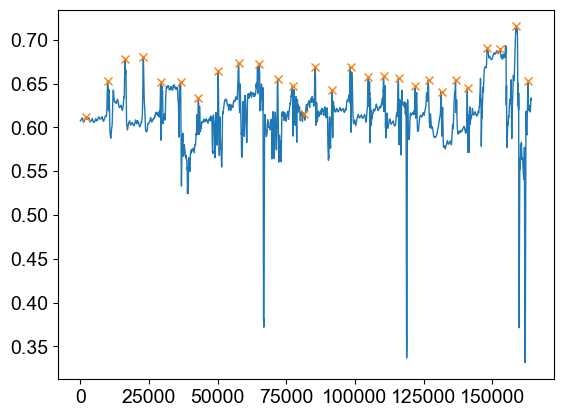

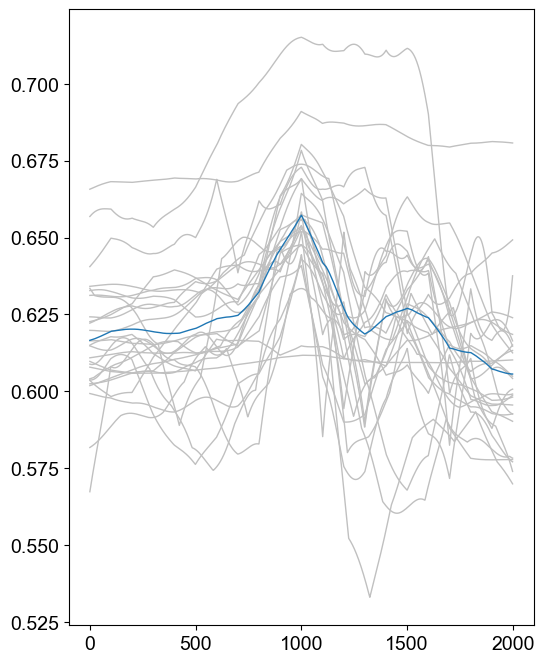

In [36]:
# throat clearing
# Load
filename = filenames[6]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(1, [3, 4], 'bandstop', output='sos', fs=1000)
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)

plt.plot(timestamps, data[:, 0])
plt.plot(peaks, data[peaks, 0], 'x')
# plt.xlim(20000, 40000)

# Construct slices_5
window_width = 2000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_5 = []
for idx in range(expanded_peaks.shape[0]):
    slices_5.append(data[expanded_peaks[idx, :]])
slices_5 = np.array(slices_5)
mask = section_average(slices_5[:, :, 0])
slices_5 = slices_5[mask.astype(bool), :, :]
slices_5 = torch.tensor(np.transpose(slices_5, (0, 2, 1)))
labels_5 = torch.broadcast_to(torch.tensor(Label.THROAT_CLEARING.value), (slices_5.shape[0], 1))
print(labels_5.shape)
print(slices_5.shape)


plt.figure(figsize=(6, 8))
for idx in range(slices_5.shape[0]):
    plt.plot(slices_5[idx, 0, :], 'silver')
plt.plot(torch.mean(slices_5[:, 0, :], axis=0))
plt.show()

In [37]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([228, 7, 2000])
torch.Size([228, 1])


In [50]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMPVBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, :4, :].transpose(0, 1), self.labels[idx]

class LHMIMUBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, 4:, :].transpose(0, 1), self.labels[idx]

class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1), self.labels[idx]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]

In [51]:
pv_biased_ds = LHMPVBiasedDataset(all_slices, all_labels)
torch.save(pv_biased_ds, '../dataset/preprocessed/pv_biased.pt')

imu_biased_ds = LHMIMUBiasedDataset(all_slices, all_labels)
torch.save(imu_biased_ds, '../dataset/preprocessed/imu_biased.pt')

mono_ds = LHMMonoDataset(all_slices, all_labels)
torch.save(mono_ds, '../dataset/preprocessed/mono.pt')

dual_ds = LHMDualDataset(all_slices, all_labels)
torch.save(dual_ds, '../dataset/preprocessed/dual.pt')

In [52]:
pv_biased_ds = torch.load('../dataset/preprocessed/pv_biased.pt')
imu_biased_ds = torch.load('../dataset/preprocessed/imu_biased.pt')
mono_ds = torch.load('../dataset/preprocessed/mono.pt')
dual_ds = torch.load('../dataset/preprocessed/dual.pt')

print(dual_ds.features.shape)
print(dual_ds.labels.shape)

torch.Size([228, 7, 2000])
torch.Size([228, 1])


In [96]:
class BaseLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class PVBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

        # self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(hidden_dim * 2, output_dim)


class IMUBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        
class MonoLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class DualLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim):
        super(DualLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward pass through first LSTM
        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))

        # Forward pass through second LSTM
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        # Pass the concatenated outputs through the fully connected layer
        out = self.fc(out)
        out = self.softmax(out)
        return out

In [94]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angl data
hidden_dim = 50
layer_dim = 1
output_dim = 6 # Number of classes

In [97]:
# Model definition
model_pv_biased = PVBiasedLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
print(model_pv_biased.to(device))

# Preparing data
batch_size = 32

total_samples = len(pv_biased_ds)
test_size = int(0.2 * total_samples)
train_size = total_samples - test_size

train_dataset_pv_biased, test_dataset_pv_biased = random_split(pv_biased_ds, [train_size, test_size])

train_loader_pv_biased = DataLoader(train_dataset_pv_biased, batch_size=batch_size, shuffle=True)
test_loader_pv_biased = DataLoader(test_dataset_pv_biased, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_pv_biased = torch.optim.Adam(model_pv_biased.parameters(), lr=0.0002, weight_decay=0.008)

# Container for losses and accuracies
train_losses_pv_biased = []
train_accuracies_pv_biased = []
test_losses_pv_biased = []
test_accuracies_pv_biased = []

num_epochs = 200

for epoch in range(num_epochs):
    model_pv_biased.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for samples, labels in train_loader_pv_biased:
        # Load data
        samples = samples.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model_pv_biased(samples)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_pv_biased.zero_grad()
        loss.backward()
        optimizer_pv_biased.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_pv_biased)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_pv_biased.append(avg_train_loss)
    train_accuracies_pv_biased.append(train_accuracy)

    model_pv_biased.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for samples, labels in test_loader_pv_biased:
            # Load data
            samples = samples.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_pv_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_pv_biased)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_pv_biased.append(avg_test_loss)
    test_accuracies_pv_biased.append(test_accuracy)

    # Print training and testing statistics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

PVBiasedLSTMModel(
  (lstm): LSTM(4, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 1.7963, Train Accuracy: 0.3005, Test Loss: 1.8081, Test Accuracy: 0.1111
Epoch [2/200], Train Loss: 1.7905, Train Accuracy: 0.3005, Test Loss: 1.8059, Test Accuracy: 0.1111
Epoch [3/200], Train Loss: 1.7836, Train Accuracy: 0.3005, Test Loss: 1.8037, Test Accuracy: 0.1111
Epoch [4/200], Train Loss: 1.7780, Train Accuracy: 0.3005, Test Loss: 1.8016, Test Accuracy: 0.1111
Epoch [5/200], Train Loss: 1.7703, Train Accuracy: 0.3005, Test Loss: 1.7994, Test Accuracy: 0.1111
Epoch [6/200], Train Loss: 1.7642, Train Accuracy: 0.3005, Test Loss: 1.7976, Test Accuracy: 0.1111
Epoch [7/200], Train Loss: 1.7583, Train Accuracy: 0.3005, Test Loss: 1.7957, Test Accuracy: 0.1111
Epoch [8/200], Train Loss: 1.7529, Train Accuracy: 0.3005, Test Loss: 1.7939, Test Accuracy: 0.1111
Epoch [9/200], Train Loss: 1.

In [74]:
# Model definition
model_imu_biased = IMUBiasedLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim, dropout_prob=0)
print(model_imu_biased.to(device))

# Preparing data
batch_size = 32

total_samples = len(imu_biased_ds)
test_size = int(0.2 * total_samples)
train_size = total_samples - test_size

train_dataset_imu_biased, test_dataset_imu_biased = random_split(imu_biased_ds, [train_size, test_size])

train_loader_imu_biased = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=True)
test_loader_imu_biased = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_imu_biased = torch.optim.Adam(model_imu_biased.parameters(), lr=0.0001, weight_decay=0.01)

# Container for losses and accuracies
train_losses_imu_biased = []
train_accuracies_imu_biased = []
test_losses_imu_biased = []
test_accuracies_imu_biased = []

num_epochs = 200

for epoch in range(num_epochs):
    model_imu_biased.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for samples, labels in train_loader_imu_biased:
        # Load data
        samples = samples.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model_imu_biased(samples)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_imu_biased.zero_grad()
        loss.backward()
        optimizer_imu_biased.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_imu_biased)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_imu_biased.append(avg_train_loss)
    train_accuracies_imu_biased.append(train_accuracy)

    model_imu_biased.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for samples, labels in test_loader_imu_biased:
            # Load data
            samples = samples.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_imu_biased)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_imu_biased.append(avg_test_loss)
    test_accuracies_imu_biased.append(test_accuracy)

    # Print training and testing statistics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

IMUBiasedLSTMModel(
  (lstm): LSTM(3, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 1.7141, Train Accuracy: 0.2077, Test Loss: 1.7554, Test Accuracy: 0.2222
Epoch [2/200], Train Loss: 1.7102, Train Accuracy: 0.2077, Test Loss: 1.7552, Test Accuracy: 0.2222
Epoch [3/200], Train Loss: 1.7142, Train Accuracy: 0.2077, Test Loss: 1.7549, Test Accuracy: 0.2222
Epoch [4/200], Train Loss: 1.7067, Train Accuracy: 0.2077, Test Loss: 1.7546, Test Accuracy: 0.2222
Epoch [5/200], Train Loss: 1.7056, Train Accuracy: 0.2077, Test Loss: 1.7542, Test Accuracy: 0.2222
Epoch [6/200], Train Loss: 1.7040, Train Accuracy: 0.2077, Test Loss: 1.7539, Test Accuracy: 0.2222
Epoch [7/200], Train Loss: 1.7040, Train Accuracy: 0.2077, Test Loss: 1.7536, Test Accuracy: 0.2222
Epoch [8/200], Train Loss: 1.7013, Train Accuracy: 0.2077, Test Loss: 1.7533, Test Accuracy: 0.2222
Epoch [9/200], Train Loss: 1.7014, Train Accuracy

In [75]:
# Model definition
model_mono = MonoLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob=0)
print(model_mono.to(device))

# Preparing data
batch_size = 32

total_samples = len(dual_ds)
test_size = int(0.2 * total_samples)
train_size = total_samples - test_size

train_dataset_mono, test_dataset_mono = random_split(mono_ds, [train_size, test_size])

train_loader_mono = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=True)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_mono = torch.optim.Adam(model_mono.parameters(), lr=0.0001, weight_decay=0.01)

# Container for losses and accuracies
train_losses_mono = []
train_accuracies_mono = []
test_losses_mono = []
test_accuracies_mono = []

num_epochs = 200

for epoch in range(num_epochs):
    model_mono.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for samples, labels in train_loader_mono:
        # Load data
        samples = samples.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model_mono(samples)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_mono.zero_grad()
        loss.backward()
        optimizer_mono.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_mono)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_mono.append(avg_train_loss)
    train_accuracies_mono.append(train_accuracy)

    model_mono.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for samples, labels in test_loader_mono:
            # Load data
            samples = samples.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_mono)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_mono.append(avg_test_loss)
    test_accuracies_mono.append(test_accuracy)

    # Print training and testing statistics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

MonoLSTMModel(
  (lstm): LSTM(7, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 1.8978, Train Accuracy: 0.0437, Test Loss: 1.8564, Test Accuracy: 0.0444
Epoch [2/200], Train Loss: 1.8960, Train Accuracy: 0.0219, Test Loss: 1.8545, Test Accuracy: 0.0222
Epoch [3/200], Train Loss: 1.8932, Train Accuracy: 0.0164, Test Loss: 1.8526, Test Accuracy: 0.0222
Epoch [4/200], Train Loss: 1.8855, Train Accuracy: 0.0164, Test Loss: 1.8507, Test Accuracy: 0.0222
Epoch [5/200], Train Loss: 1.8906, Train Accuracy: 0.0109, Test Loss: 1.8488, Test Accuracy: 0.0444
Epoch [6/200], Train Loss: 1.8836, Train Accuracy: 0.0109, Test Loss: 1.8469, Test Accuracy: 0.0444
Epoch [7/200], Train Loss: 1.8789, Train Accuracy: 0.0109, Test Loss: 1.8449, Test Accuracy: 0.0444
Epoch [8/200], Train Loss: 1.8765, Train Accuracy: 0.0109, Test Loss: 1.8431, Test Accuracy: 0.0444
Epoch [9/200], Train Loss: 1.8770, Train Accuracy: 0.0

In [77]:


# Model definition
model_dual = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim)
print(model_dual.to(device))

# Preparing data
batch_size = 32

total_samples = len(dual_ds)
test_size = int(0.2 * total_samples)
train_size = total_samples - test_size

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])

train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(model_dual.parameters(), lr=0.0005, weight_decay=0.01)

# Container for losses and accuracies
train_losses_dual = []
train_accuracies_dual = []
test_losses_dual = []
test_accuracies_dual = []

num_epochs = 200

for epoch in range(num_epochs):
    model_dual.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        # Load data
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)

        # Forward pass
        outputs = model_dual(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_dual.zero_grad()
        loss.backward()
        optimizer_dual.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_dual.append(avg_train_loss)
    train_accuracies_dual.append(train_accuracy)

    model_dual.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_dual.append(avg_test_loss)
    test_accuracies_dual.append(test_accuracy)

    # Print training and testing statistics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

DualLSTMModel(
  (lstm1): LSTM(4, 10, batch_first=True)
  (lstm2): LSTM(3, 10, batch_first=True)
  (fc): Linear(in_features=20, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 1.7737, Train Accuracy: 0.1530, Test Loss: 1.8089, Test Accuracy: 0.1333
Epoch [2/200], Train Loss: 1.7630, Train Accuracy: 0.1530, Test Loss: 1.7967, Test Accuracy: 0.1333
Epoch [3/200], Train Loss: 1.7505, Train Accuracy: 0.1585, Test Loss: 1.7882, Test Accuracy: 0.1333
Epoch [4/200], Train Loss: 1.7398, Train Accuracy: 0.1803, Test Loss: 1.7797, Test Accuracy: 0.1778
Epoch [5/200], Train Loss: 1.7273, Train Accuracy: 0.2842, Test Loss: 1.7682, Test Accuracy: 0.2000
Epoch [6/200], Train Loss: 1.7176, Train Accuracy: 0.3060, Test Loss: 1.7603, Test Accuracy: 0.2000
Epoch [7/200], Train Loss: 1.7102, Train Accuracy: 0.3224, Test Loss: 1.7615, Test Accuracy: 0.2000
Epoch [8/200], Train Loss: 1.6975, Train Accuracy: 0.3333, Test Loss: 1.7542, Test Accuracy: 0.2000
Epoch [9/200

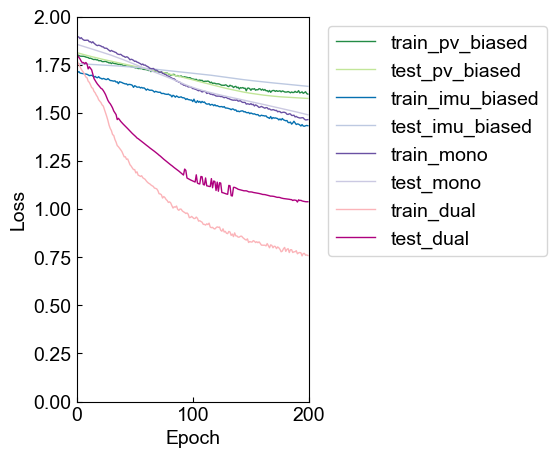

In [78]:
fig = plt.figure(figsize=[3, 5])
ax = fig.add_subplot()

ax.plot(train_losses_pv_biased, linewidth=1, c='#238b45', label='train_pv_biased')
ax.plot(test_losses_pv_biased, linewidth=1, c='#c2e699', label='test_pv_biased')

ax.plot(train_losses_imu_biased, linewidth=1, c='#0570b0', label='train_imu_biased')
ax.plot(test_losses_imu_biased, linewidth=1, c='#bdc9e1', label='test_imu_biased')

ax.plot(train_losses_mono, linewidth=1, c='#6a51a3', label='train_mono')
ax.plot(test_losses_mono, linewidth=1, c='#cbc9e2', label='test_mono')

ax.plot(train_losses_dual, linewidth=1, c='#fbb4b9', label='train_dual')
ax.plot(test_losses_dual, linewidth=1, c='#ae017e', label='test_dual')
# ax.vlines(100, 0, 2,
#           linewidth=1,
#           linestyles=(0, (5, 5)),
#           colors='lightgray')

ax.set_xlim(0, 200)
ax.set_ylim(0, 2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# plt.savefig('../results/fig3/loss.png', dpi=600, bbox_inches='tight')
plt.show()

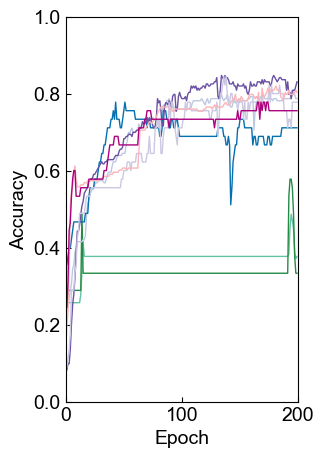

In [64]:
fig = plt.figure(figsize=[3, 5])
ax = fig.add_subplot()

ax.plot(train_accuracies_pv_biased, linewidth=1, c='#66c2a4')
ax.plot(test_accuracies_pv_biased, linewidth=1, c='#238b45')

ax.plot(train_accuracies_imu_biased, linewidth=1, c='#bdc9e1')
ax.plot(test_accuracies_imu_biased, linewidth=1, c='#0570b0')

ax.plot(train_accuracies_mono, linewidth=1, c='#6a51a3')
ax.plot(test_accuracies_mono, linewidth=1, c='#cbc9e2')

ax.plot(train_accuracies_dual, linewidth=1, c='#fbb4b9')
ax.plot(test_accuracies_dual, linewidth=1, c='#ae017e')
# ax.vlines(100, 0, 2,
#           linewidth=1,
#           linestyles=(0, (5, 5)),
#           colors='lightgray')

ax.set_xlim(0, 200)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')

# plt.savefig('../results/fig3/accuracy.png', dpi=600, bbox_inches='tight')
plt.show()

In [35]:
model_dual.eval()

incorrect_train_samples = []
incorrect_test_samples = []

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_train_samples.extend(zip(*incorrect_predictions))

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in test_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        # Forward pass
        outputs = model_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_test_samples.extend(zip(*incorrect_predictions))

incorrect_train_samples = incorrect_train_samples[:5]
incorrect_test_samples = incorrect_test_samples[:5]

In [47]:
def plot_incorrect_samples(samples, title):
    plt.figure(figsize=(5, 15))
    for i, (photovoltage, euler_angle, true_label, pred_label) in enumerate(samples):
        # Creating a subplot for each sample
        plt.subplot(len(samples), 2, 2*i + 1)  # Photovoltage plot
        plt.plot(photovoltage.numpy())  # Assuming photovoltage is a waveform
        plt.title(f'Sample {i}: True Label = {true_label.item()}, Predicted = {pred_label.item()}')
        plt.ylabel('Photovoltage')

        plt.subplot(len(samples), 2, 2*i + 2)  # Euler angle plot
        plt.plot(euler_angle.numpy())  # Assuming euler_angle is a waveform
        plt.ylabel('Euler Angles')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

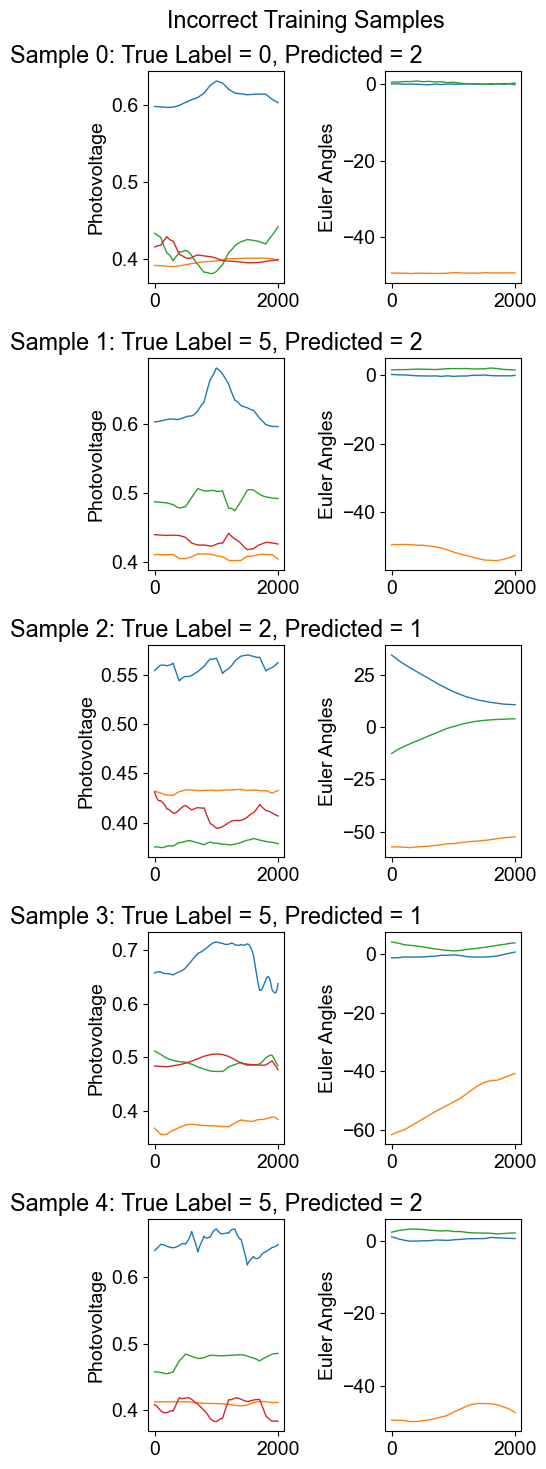

In [48]:
plot_incorrect_samples(incorrect_train_samples, "Incorrect Training Samples")